In [5]:
import matplotlib.pyplot as plt


def sample_batch(dataset):
    batch = dataset.take(1).get_single_element()
    if isinstance(batch, tuple):
        batch = batch[0]
    return batch.numpy()


def display(
    images, n=10, size=(20, 3), cmap="gray_r", as_type="float32", save_to=None
):
    """
    Displays n random images from each one of the supplied arrays.
    """
    if images.max() > 1.0:
        images = images / 255.0
    elif images.min() < 0.0:
        images = (images + 1.0) / 2.0

    plt.figure(figsize=size)
    for i in range(n):
        _ = plt.subplot(1, n, i + 1)
        plt.imshow(images[i].astype(as_type), cmap=cmap)
        plt.axis("off")

    if save_to:
        plt.savefig(save_to)
        print(f"\nSaved to {save_to}")

    plt.show()

In [6]:
import numpy as np
import matplotlib.pyplot as plt


def get_vector_from_label(data, vae, embedding_dim, label):
    current_sum_POS = np.zeros(shape=embedding_dim, dtype="float32")
    current_n_POS = 0
    current_mean_POS = np.zeros(shape=embedding_dim, dtype="float32")

    current_sum_NEG = np.zeros(shape=embedding_dim, dtype="float32")
    current_n_NEG = 0
    current_mean_NEG = np.zeros(shape=embedding_dim, dtype="float32")

    current_vector = np.zeros(shape=embedding_dim, dtype="float32")
    current_dist = 0

    print("label: " + label)
    print("images : POS move : NEG move :distance : 𝛥 distance")
    while current_n_POS < 10000:
        batch = list(data.take(1).get_single_element())
        im = batch[0]
        attribute = batch[1]

        _, _, z = vae.encoder.predict(np.array(im), verbose=0)

        z_POS = z[attribute == 1]
        z_NEG = z[attribute == -1]

        if len(z_POS) > 0:
            current_sum_POS = current_sum_POS + np.sum(z_POS, axis=0)
            current_n_POS += len(z_POS)
            new_mean_POS = current_sum_POS / current_n_POS
            movement_POS = np.linalg.norm(new_mean_POS - current_mean_POS)

        if len(z_NEG) > 0:
            current_sum_NEG = current_sum_NEG + np.sum(z_NEG, axis=0)
            current_n_NEG += len(z_NEG)
            new_mean_NEG = current_sum_NEG / current_n_NEG
            movement_NEG = np.linalg.norm(new_mean_NEG - current_mean_NEG)

        current_vector = new_mean_POS - new_mean_NEG
        new_dist = np.linalg.norm(current_vector)
        dist_change = new_dist - current_dist

        print(
            str(current_n_POS)
            + "    : "
            + str(np.round(movement_POS, 3))
            + "    : "
            + str(np.round(movement_NEG, 3))
            + "    : "
            + str(np.round(new_dist, 3))
            + "    : "
            + str(np.round(dist_change, 3))
        )

        current_mean_POS = np.copy(new_mean_POS)
        current_mean_NEG = np.copy(new_mean_NEG)
        current_dist = np.copy(new_dist)

        if np.sum([movement_POS, movement_NEG]) < 0.08:
            current_vector = current_vector / current_dist
            print("Found the " + label + " vector")
            break

    return current_vector


def add_vector_to_images(data, vae, feature_vec):
    n_to_show = 5
    factors = [-4, -3, -2, -1, 0, 1, 2, 3, 4]

    example_batch = list(data.take(1).get_single_element())
    example_images = example_batch[0]

    _, _, z_points = vae.encoder.predict(example_images, verbose=0)

    fig = plt.figure(figsize=(18, 10))

    counter = 1

    for i in range(n_to_show):
        img = example_images[i]
        sub = fig.add_subplot(n_to_show, len(factors) + 1, counter)
        sub.axis("off")
        sub.imshow(img)

        counter += 1

        for factor in factors:
            changed_z_point = z_points[i] + feature_vec * factor
            changed_image = vae.decoder.predict(
                np.array([changed_z_point]), verbose=0
            )[0]

            sub = fig.add_subplot(n_to_show, len(factors) + 1, counter)
            sub.axis("off")
            sub.imshow(changed_image)

            counter += 1

    plt.show()


def morph_faces(data, vae):
    factors = np.arange(0, 1, 0.1)

    example_batch = list(data.take(1).get_single_element())[:2]
    example_images = example_batch[0]
    _, _, z_points = vae.encoder.predict(example_images, verbose=0)

    fig = plt.figure(figsize=(18, 8))

    counter = 1

    img = example_images[0]
    sub = fig.add_subplot(1, len(factors) + 2, counter)
    sub.axis("off")
    sub.imshow(img)

    counter += 1

    for factor in factors:
        changed_z_point = z_points[0] * (1 - factor) + z_points[1] * factor
        changed_image = vae.decoder.predict(
            np.array([changed_z_point]), verbose=0
        )[0]
        sub = fig.add_subplot(1, len(factors) + 2, counter)
        sub.axis("off")
        sub.imshow(changed_image)

        counter += 1

    img = example_images[1]
    sub = fig.add_subplot(1, len(factors) + 2, counter)
    sub.axis("off")
    sub.imshow(img)

    plt.show()

In [7]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import (
    layers,
    models,
    callbacks,
    utils,
    metrics,
    losses,
    optimizers,
)

from scipy.stats import norm
import pandas as pd

In [8]:
IMAGE_SIZE = 32
CHANNELS = 3
BATCH_SIZE = 128
NUM_FEATURES = 128
Z_DIM = 200
LEARNING_RATE = 0.0005
EPOCHS = 10
BETA = 2000
LOAD_MODEL = False

In [9]:
import os
import tensorflow as tf

SEED = 42

kaggle_path = "/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba"
image_dir = kaggle_path

print("Using images from:", image_dir)

# Build tf.data pipeline
train_data = tf.keras.utils.image_dataset_from_directory(
    image_dir,
    labels=None,                # unlabeled image batches
    color_mode="rgb",
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=SEED,
    interpolation="bilinear",
)

# Recommended performance tweaks on Kaggle
AUTOTUNE = tf.data.AUTOTUNE
train_data = train_data.cache() \
                       .shuffle(1024) \
                       .prefetch(AUTOTUNE)

# Sanity check a batch
for images in train_data.take(1):
    print("Batch shape:", images.shape)


Using images from: /kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba
Found 202599 files.


I0000 00:00:1758887483.721837      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Batch shape: (128, 32, 32, 3)


In [10]:
# Preprocess the data
def preprocess(img):
    img = tf.cast(img, "float32") / 255.0
    return img


train = train_data.map(lambda x: preprocess(x))

In [11]:
train_sample = sample_batch(train)

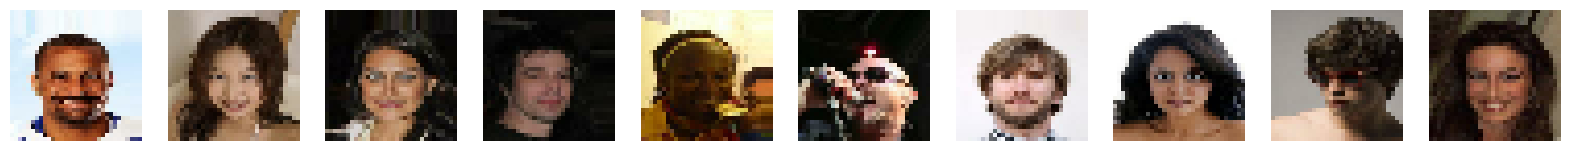

In [12]:
# Show some faces from the training set
display(train_sample, cmap=None)

In [13]:
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = K.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [14]:
# Encoder
encoder_input = layers.Input(
    shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS), name="encoder_input"
)
x = layers.Conv2D(NUM_FEATURES, kernel_size=3, strides=2, padding="same")(
    encoder_input
)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(NUM_FEATURES, kernel_size=3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(NUM_FEATURES, kernel_size=3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(NUM_FEATURES, kernel_size=3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
shape_before_flattening = K.int_shape(x)[1:]  # the decoder will need this!

x = layers.Flatten()(x)
z_mean = layers.Dense(Z_DIM, name="z_mean")(x)
z_log_var = layers.Dense(Z_DIM, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])

encoder = models.Model(encoder_input, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 16, 16,    │      3,584 │ encoder_input[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 16, 16,    │        512 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 8, 8, 128) │    147,584 │ leaky_re_lu[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 128) │        512 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_1       │ (None, 8, 8, 128) │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 4, 4, 128) │    147,584 │ leaky_re_lu_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 4, 4, 128) │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_2       │ (None, 4, 4, 128) │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 2, 2, 128) │    147,584 │ leaky_re_lu_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 2, 2, 128) │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_3       │ (None, 2, 2, 128) │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 512)       │          0 │ leaky_re_lu_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 200)       │    102,600 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 200)       │    102,600 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling (Sampling) │ (None, 200)       │          0 │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 653,584 (2.49 MB)

 Trainable params: 652,560 (2.49 MB)

 Non-trainable params: 1,024 (4.00 KB)

In [15]:
# Decoder
decoder_input = layers.Input(shape=(Z_DIM,), name="decoder_input")
x = layers.Dense(np.prod(shape_before_flattening))(decoder_input)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Reshape(shape_before_flattening)(x)
x = layers.Conv2DTranspose(
    NUM_FEATURES, kernel_size=3, strides=2, padding="same"
)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2DTranspose(
    NUM_FEATURES, kernel_size=3, strides=2, padding="same"
)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2DTranspose(
    NUM_FEATURES, kernel_size=3, strides=2, padding="same"
)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2DTranspose(
    NUM_FEATURES, kernel_size=3, strides=2, padding="same"
)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
decoder_output = layers.Conv2DTranspose(
    CHANNELS, kernel_size=3, strides=1, activation="sigmoid", padding="same"
)(x)
decoder = models.Model(decoder_input, decoder_output)
decoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)      │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       102,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 4, 4, 128)      │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 4, 4, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 8, 8, 128)      │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 16, 16, 128)    │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_7 (LeakyReLU)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 32, 32, 128)    │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_8 (LeakyReLU)       │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 32, 32, 3)      │         3,459 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 700,803 (2.67 MB)

 Trainable params: 698,755 (2.67 MB)

 Non-trainable params: 2,048 (8.00 KB)

In [16]:
class VAE(models.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = metrics.Mean(name="kl_loss")
        self.mse = tf.keras.losses.MeanSquaredError(
            reduction=tf.keras.losses.Reduction.NONE
        )

    @property
    def metrics(self):
        # Only include trackers that actually exist
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def _recon_mse(self, y_true, y_pred):
        # flatten per-sample, compute MSE per-sample, then mean over batch
        y_true = tf.reshape(y_true, [tf.shape(y_true)[0], -1])
        y_pred = tf.reshape(y_pred, [tf.shape(y_pred)[0], -1])
        per_example = self.mse(y_true, y_pred)  # shape: (batch,)
        return tf.reduce_mean(BETA * per_example)

    def call(self, inputs, training=False):
        # Use self.encoder / self.decoder (not globals)
        z_mean, z_log_var, z = self.encoder(inputs, training=training)
        reconstruction = self.decoder(z, training=training)
        return z_mean, z_log_var, reconstruction

    def train_step(self, data):
        # Handle (x,) or (x, y) gracefully
        if isinstance(data, tuple):
            data = data[0]

        with tf.GradientTape() as tape:
            z_mean, z_log_var, reconstruction = self(data, training=True)
            reconstruction_loss = self._recon_mse(data, reconstruction)
            kl_loss = tf.reduce_mean(
                tf.reduce_sum(
                    -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                    axis=1,
                )
            )
            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def test_step(self, data):
        if isinstance(data, tuple):
            data = data[0]

        z_mean, z_log_var, reconstruction = self(data, training=False)
        reconstruction_loss = self._recon_mse(data, reconstruction)
        kl_loss = tf.reduce_mean(
            tf.reduce_sum(
                -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                axis=1,
            )
        )
        total_loss = reconstruction_loss + kl_loss

        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }


In [22]:
# Create a variational autoencoder
vae = VAE(encoder, decoder)

In [23]:
# Compile the variational autoencoder
optimizer = optimizers.Adam(learning_rate=LEARNING_RATE)
vae.compile(optimizer=optimizer)

In [24]:
base = "/kaggle/working/"

In [25]:
# Create a model save checkpoint
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath=os.path.join(base, "checkpoint.keras"),
    save_weights_only=False,
    save_freq="epoch",
    monitor="loss",
    mode="min",
    save_best_only=True,
    verbose=0,
)

tensorboard_callback = callbacks.TensorBoard(log_dir=os.path.join(base, "logs"))

full_path = os.path.join(base, 'output')
os.mkdir(full_path)

class ImageGenerator(callbacks.Callback):
    def __init__(self, num_img, latent_dim):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(
            shape=(self.num_img, self.latent_dim)
        )
        generated_images = self.model.decoder(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = utils.array_to_img(generated_images[i])
            img.save(os.path.join(base, "output/generated_img_%03d_%d.png") % (epoch, i))

In [26]:
vae.fit(
    train,
    epochs=EPOCHS,
    callbacks=[
        model_checkpoint_callback,
        tensorboard_callback,
        ImageGenerator(num_img=10, latent_dim=Z_DIM),
    ],
)

Epoch 1/10
1583/1583 ━━━━━━━━━━━━━━━━━━━━ 50s 24ms/step - kl_loss: 15.9142 - loss: 69.1135 - reconstruction_loss: 53.1993
Epoch 2/10
1583/1583 ━━━━━━━━━━━━━━━━━━━━ 33s 21ms/step - kl_loss: 16.3626 - loss: 66.6520 - reconstruction_loss: 50.2895
Epoch 3/10
1583/1583 ━━━━━━━━━━━━━━━━━━━━ 33s 21ms/step - kl_loss: 16.7151 - loss: 65.5152 - reconstruction_loss: 48.8000
Epoch 4/10
1583/1583 ━━━━━━━━━━━━━━━━━━━━ 33s 21ms/step - kl_loss: 16.9861 - loss: 64.9087 - reconstruction_loss: 47.9226
Epoch 5/10
1583/1583 ━━━━━━━━━━━━━━━━━━━━ 33s 21ms/step - kl_loss: 17.1936 - loss: 64.3747 - reconstruction_loss: 47.1811
Epoch 6/10
1583/1583 ━━━━━━━━━━━━━━━━━━━━ 33s 21ms/step - kl_loss: 17.3976 - loss: 63.9871 - reconstruction_loss: 46.5895
Epoch 7/10
1583/1583 ━━━━━━━━━━━━━━━━━━━━ 33s 21ms/step - kl_loss: 17.5230 - loss: 63.8267 - reconstruction_loss: 46.3036
Epoch 8/10
1583/1583 ━━━━━━━━━━━━━━━━━━━━ 33s 21ms/step - kl_loss: 17.5480 - loss: 63.5852 - reconstruction_loss: 46.0371
Epoch 9/10
1583/1583 ━━━

In [28]:
full_path = os.path.join(base, 'models')
os.mkdir(full_path)

In [29]:
# Save the final models
vae.save(os.path.join(base, "models/vae.keras"))
encoder.save(os.path.join(base, "models/encoder.keras"))
decoder.save(os.path.join(base, "models/decoder.keras"))

In [30]:
# Select a subset of the test set
batches_to_predict = 1
example_images = np.array(
    list(train.take(batches_to_predict).get_single_element())
)

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
Example real faces


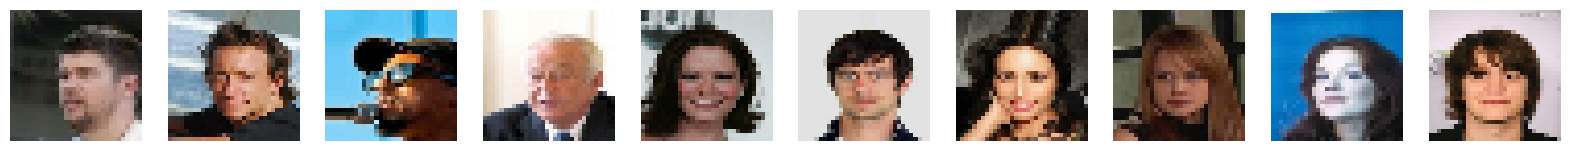

Reconstructions


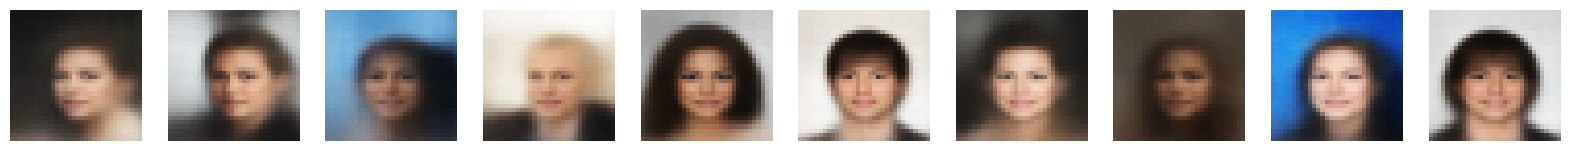

In [31]:
# Create autoencoder predictions and display
z_mean, z_log_var, reconstructions = vae.predict(example_images)
print("Example real faces")
display(example_images)
print("Reconstructions")
display(reconstructions)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step  


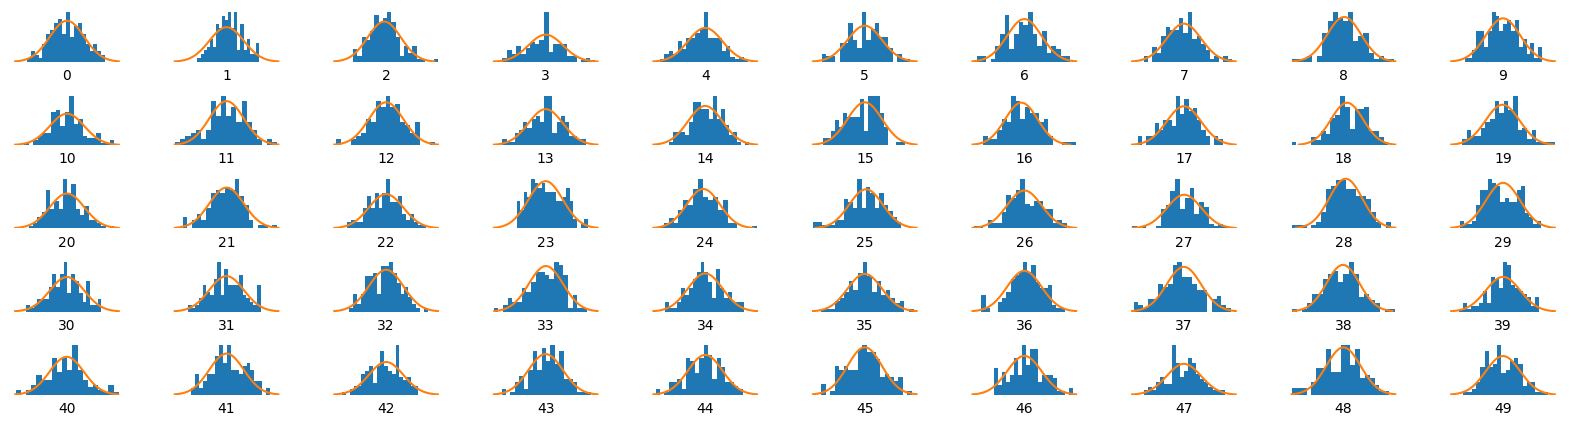

In [32]:
_, _, z = vae.encoder.predict(example_images)

x = np.linspace(-3, 3, 100)

fig = plt.figure(figsize=(20, 5))
fig.subplots_adjust(hspace=0.6, wspace=0.4)

for i in range(50):
    ax = fig.add_subplot(5, 10, i + 1)
    ax.hist(z[:, i], density=True, bins=20)
    ax.axis("off")
    ax.text(
        0.5, -0.35, str(i), fontsize=10, ha="center", transform=ax.transAxes
    )
    ax.plot(x, norm.pdf(x))

plt.show()

In [33]:
# Sample some points in the latent space, from the standard normal distribution
grid_width, grid_height = (10, 3)
z_sample = np.random.normal(size=(grid_width * grid_height, Z_DIM))

In [34]:
# Decode the sampled points
reconstructions = decoder.predict(z_sample)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 666ms/step


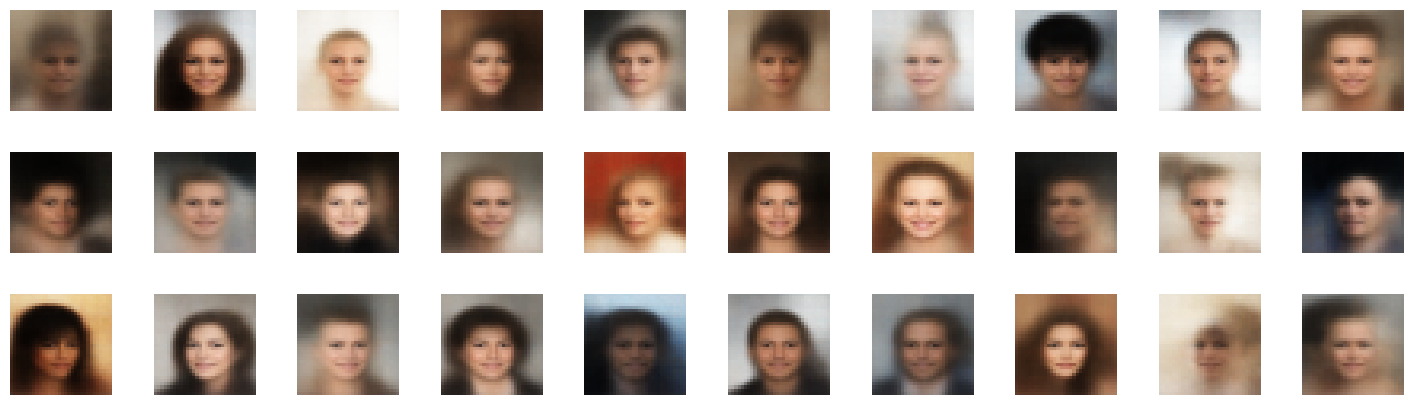

In [35]:
# Draw a plot of decoded images
fig = plt.figure(figsize=(18, 5))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

# Output the grid of faces
for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")
    ax.imshow(reconstructions[i, :, :])

In [36]:
# Load the label dataset (attributes)
attributes = pd.read_csv("/kaggle/input/celeba-dataset/list_attr_celeba.csv")

# Display the columns of the dataset
print(attributes.columns)

# Display the first few rows of the dataset
attributes.head()


Index(['image_id', '5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive',
       'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose',
       'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows',
       'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair',
       'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open',
       'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin',
       'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns',
       'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings',
       'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace',
       'Wearing_Necktie', 'Young'],
      dtype='object')


,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,...,-1,1,1,-1,1,-1,1,-1,-1,1
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,1,-1,-1,-1,-1,-1,1
3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,1,-1,1,1,-1,1
4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1


In [38]:
LABEL = "Blond_Hair"
# Prepare the labels (get the chosen attribute column and convert to list)
labels = attributes[LABEL].tolist()

# Load the image dataset with the labels attached
image_dir = "/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba"

# Use validation split
labelled_test = tf.keras.preprocessing.image_dataset_from_directory(
    image_dir,
    labels=labels,
    color_mode="rgb",
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset="validation",  # Specify validation split
    interpolation="bilinear",
)

# You can preprocess the images further if necessary
def preprocess(image):
    # Add your preprocessing here if needed
    # Example: Normalization or resizing can be done here
    image = tf.cast(image, tf.float32) / 255.0
    return image

# Map the preprocessing function to the dataset
labelled = labelled_test.map(lambda x, y: (preprocess(x), y))

# Verify the data
for images, labels in labelled.take(1):
    print("Batch shape:", images.shape, "Labels:", labels.numpy())


Found 202599 files belonging to 2 classes.
Using 40519 files for validation.
Batch shape: (128, 32, 32, 3) Labels: [-1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1 -1  1 -1 -1 -1 -1
 -1 -1 -1 -1  1  1 -1 -1  1 -1 -1 -1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1
 -1 -1 -1  1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1  1 -1 -1  1 -1 -1 -1  1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1
 -1  1 -1 -1  1 -1  1 -1 -1 -1 -1 -1  1 -1 -1  1 -1 -1 -1 -1 -1 -1  1 -1
  1 -1  1 -1 -1 -1 -1 -1]


In [39]:
# Find the attribute vector
attribute_vec = get_vector_from_label(labelled, vae, Z_DIM, LABEL)

label: Blond_Hair
images : POS move : NEG move :distance : 𝛥 distance
22    : 3.361    : 1.493    : 3.928    : 3.928
43    : 2.008    : 1.027    : 2.99    : -0.938
65    : 1.213    : 0.571    : 2.528    : -0.462
88    : 0.901    : 0.393    : 2.196    : -0.332
106    : 0.603    : 0.322    : 2.053    : -0.143
128    : 0.576    : 0.238    : 1.937    : -0.115
149    : 0.45    : 0.21    : 1.886    : -0.051
175    : 0.405    : 0.184    : 1.832    : -0.054
196    : 0.372    : 0.171    : 1.768    : -0.064
219    : 0.308    : 0.145    : 1.745    : -0.023
238    : 0.268    : 0.126    : 1.726    : -0.019
260    : 0.254    : 0.113    : 1.724    : -0.003
280    : 0.246    : 0.109    : 1.682    : -0.042
295    : 0.179    : 0.109    : 1.674    : -0.008
315    : 0.229    : 0.095    : 1.668    : -0.007
334    : 0.189    : 0.08    : 1.633    : -0.035
355    : 0.185    : 0.09    : 1.617    : -0.016
373    : 0.16    : 0.082    : 1.586    : -0.031
393    : 0.153    : 0.07    : 1.599    : 0.013
414    : 0.1

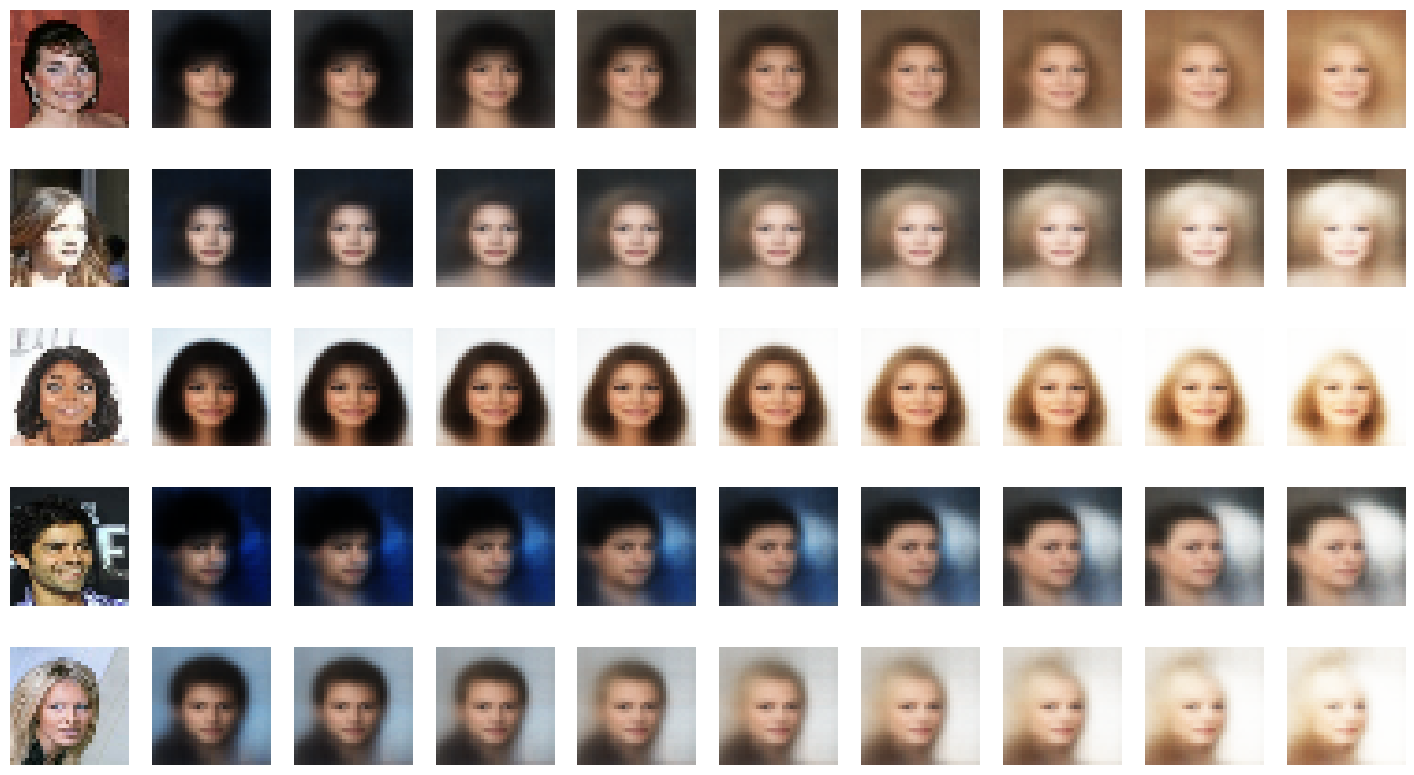

In [40]:
# Add vector to images
add_vector_to_images(labelled, vae, attribute_vec)

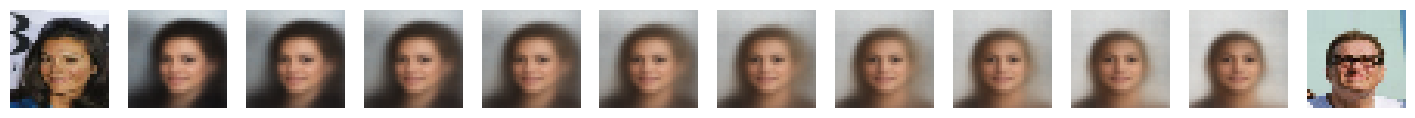

In [41]:
morph_faces(labelled, vae)